<a href="https://colab.research.google.com/github/skrofman/Applied-Machine-Learning/blob/master/DATA_310_Lecture_12_Spring_2021(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA 310 Lecture 12 - Spring 2021

<font face="Chalkboard" color="darkgreen" size=6.5> The Effects of Regularization</font>

In [ ]:
# general imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from yellowbrick.regressor import ResidualsPlot

# Load a regression dataset, i.e. https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength
df = pd.read_csv('drive/MyDrive/Colab Notebooks/concrete.csv')
# we get the input and the output as numerical arrays
y = df['strength'].values
X = df.loc[ : , df.columns != 'strength'].values
Xf = df.loc[ : , df.columns != 'strength']

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
X.shape

(1030, 8)

In [ ]:
# this is the coefficient of determination aka R^2
def R2(yhat,y):
  return 1 - np.sum((y-yhat)**2)/np.sum((y-np.mean(y))**2)

## Critical Thinking Question: How do we know we may need regularization?

- check the shape of the data
- check the correlation structure of the input features.

### Test statistic for the corelation coefficient:

$$\large t=\frac{r\sqrt{n-2}}{\sqrt{1-r^2}}$$

where $n$ is the number of observations and $r$ represents the correlation coefficient computed from the data.

In [ ]:
X.shape # this does not need anything special

(1030, 8)

In [ ]:
from scipy import stats
n = len(X)
r = 0.08
# test statistic 
t = r*np.sqrt(n-2)/np.sqrt(1-r**2)
pval = stats.t.sf(np.abs(t), n-1)*2  # two-sided pvalue = Prob(abs(t)>tt)
print('t-statistic = %6.3f pvalue = %6.4f' % (t, pval))

t-statistic =  2.573 pvalue = 0.0102


In [ ]:
def tstat_corr(r,n):
  t = r*np.sqrt(n-2)/np.sqrt(1-r**2)
  pval = stats.t.sf(np.abs(t), n-1)*2  # two-sided pvalue = Prob(abs(t)>tt)
  print('t-statistic = %6.3f pvalue = %6.4f' % (t, pval))


In [ ]:
tstat_corr(0.1,len(X))

t-statistic =  3.222 pvalue = 0.0013


In [ ]:
feature_names = df.columns

### Message: we got strong multiple linear correlations among the input features so we NEED regularization because we are in "rank deffficient situation"

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

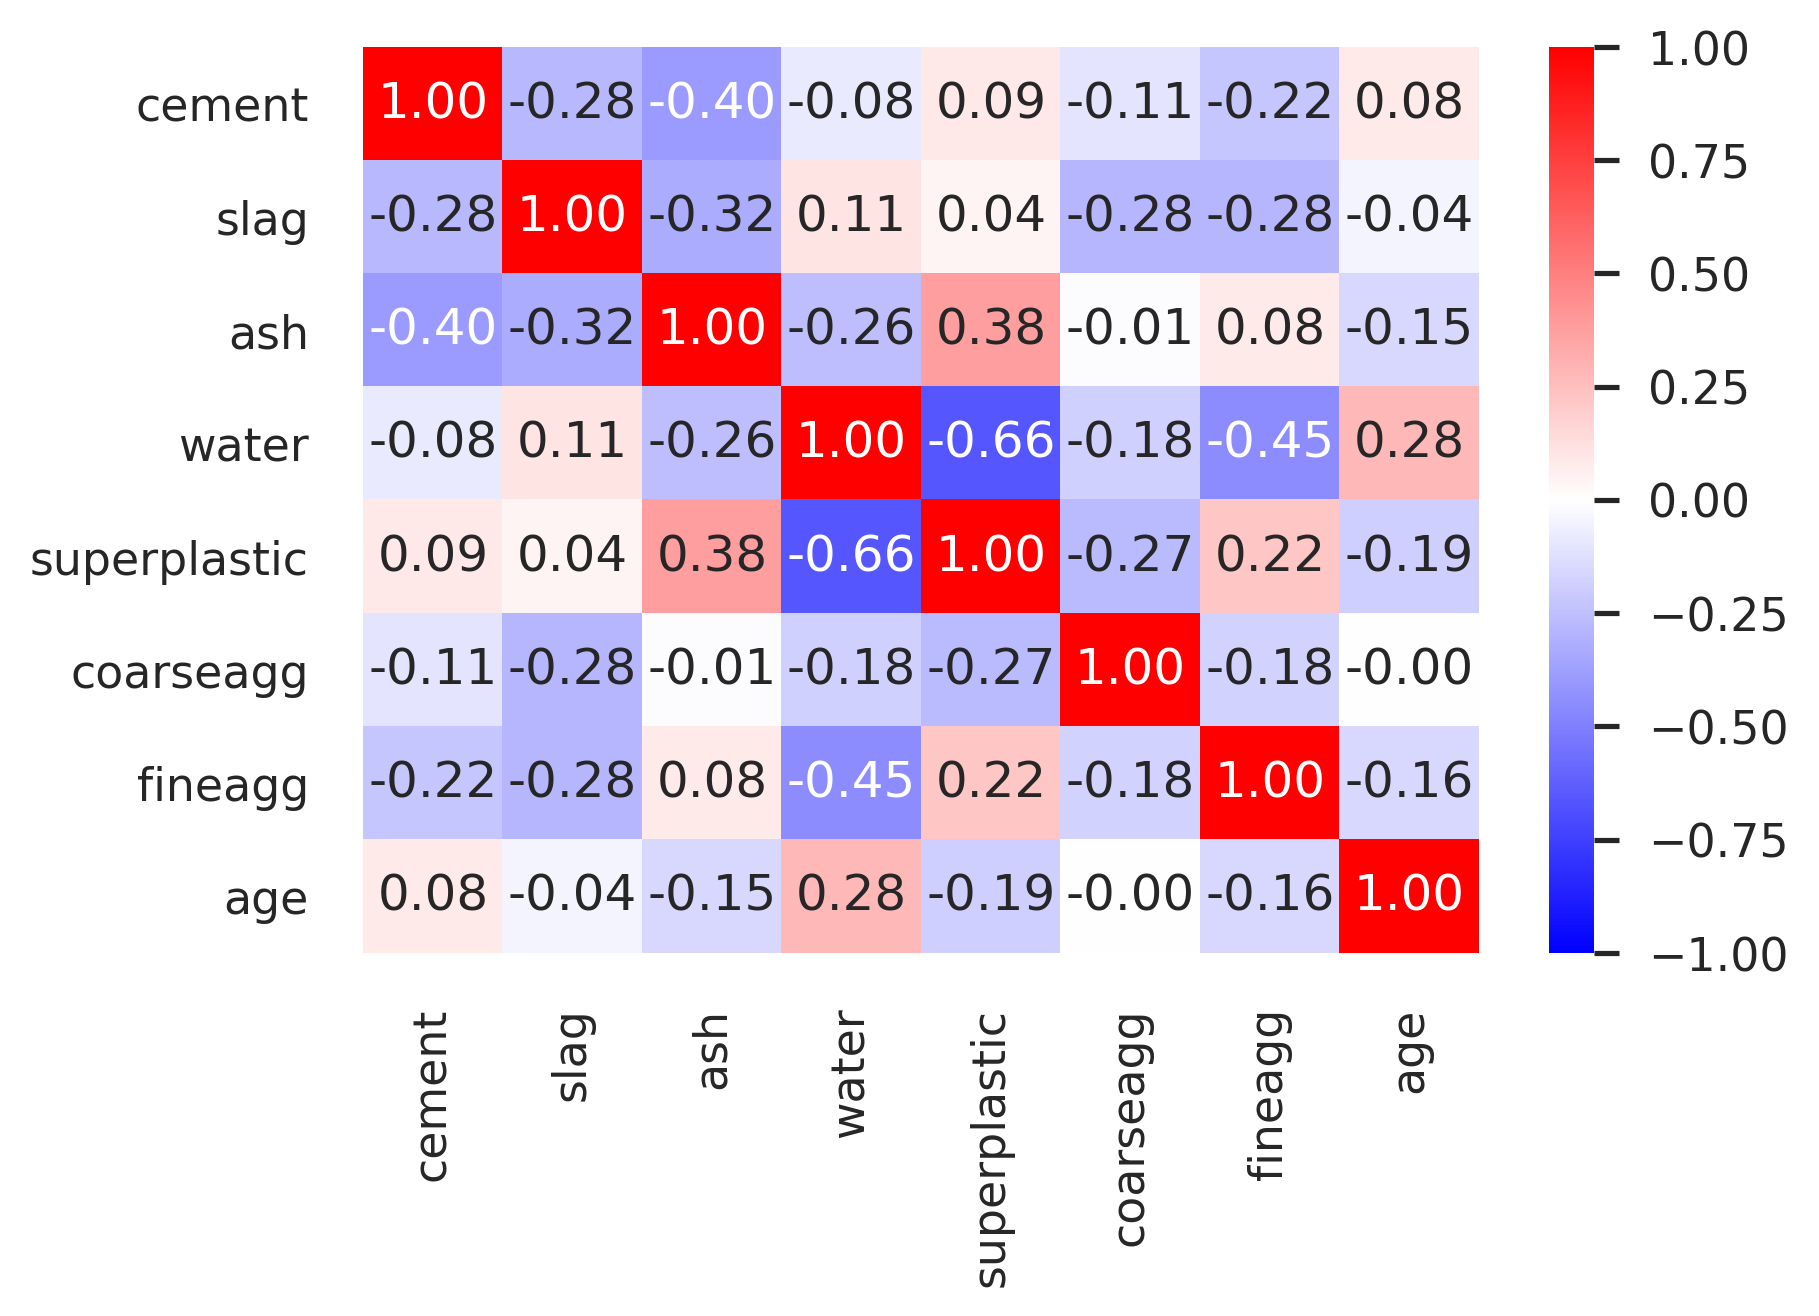

In [ ]:
sns.set(color_codes=True)
cols = Xf.columns
sns.heatmap(np.corrcoef(np.transpose(X)),cmap='bwr',vmin=-1,vmax=1,annot=True,fmt='.2f',xticklabels=cols,yticklabels=cols)
plt.show()

In [ ]:
tstat_corr(0.09,len(X))
# yes this is a significant correlation that we cannot neglect !

t-statistic =  2.897 pvalue = 0.0038


In [ ]:
tstat_corr(-0.26,len(X))
# this is very significant !!

t-statistic = -8.633 pvalue = 0.0000


### Message: we found multiple significant correlations among the input features that need too be addressed by regularization.

Example of spurious correlations: https://www.tylervigen.com/spurious-correlations

### Why we need data scaling?

IMPORTANT: in linear models we need scaling so we can combine feature values that are on the same units of measurement. 

$$\hat{y} = w_1 \cdot x_1 + w_2\cdot x_2 + w_3\cdot x_3 +...w_p\cdot x_p$$

In [ ]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=2021)
Xs_train = scale.fit_transform(X_train)
Xs_test  = scale.transform(X_test)

In [ ]:
model = Ridge(alpha=0.1)
model.fit(Xs_train, y_train)
yhat =  model.predict(Xs_test)
residuals = y_test - yhat

In [ ]:
# this is the coefficient of determination aka R^2
def R2(yhat,y):
  return 1 - np.sum((y-yhat)**2)/np.sum((y-np.mean(y))**2)

In [ ]:
R2(yhat,y_test)

0.5624211997711455

In [ ]:
model = Ridge(alpha=0.75)
model.fit(Xs_train, y_train)
yhat =  model.predict(Xs_train)
residuals = y_train - yhat

In [ ]:
R2(yhat,y_train)

0.6361955816788343

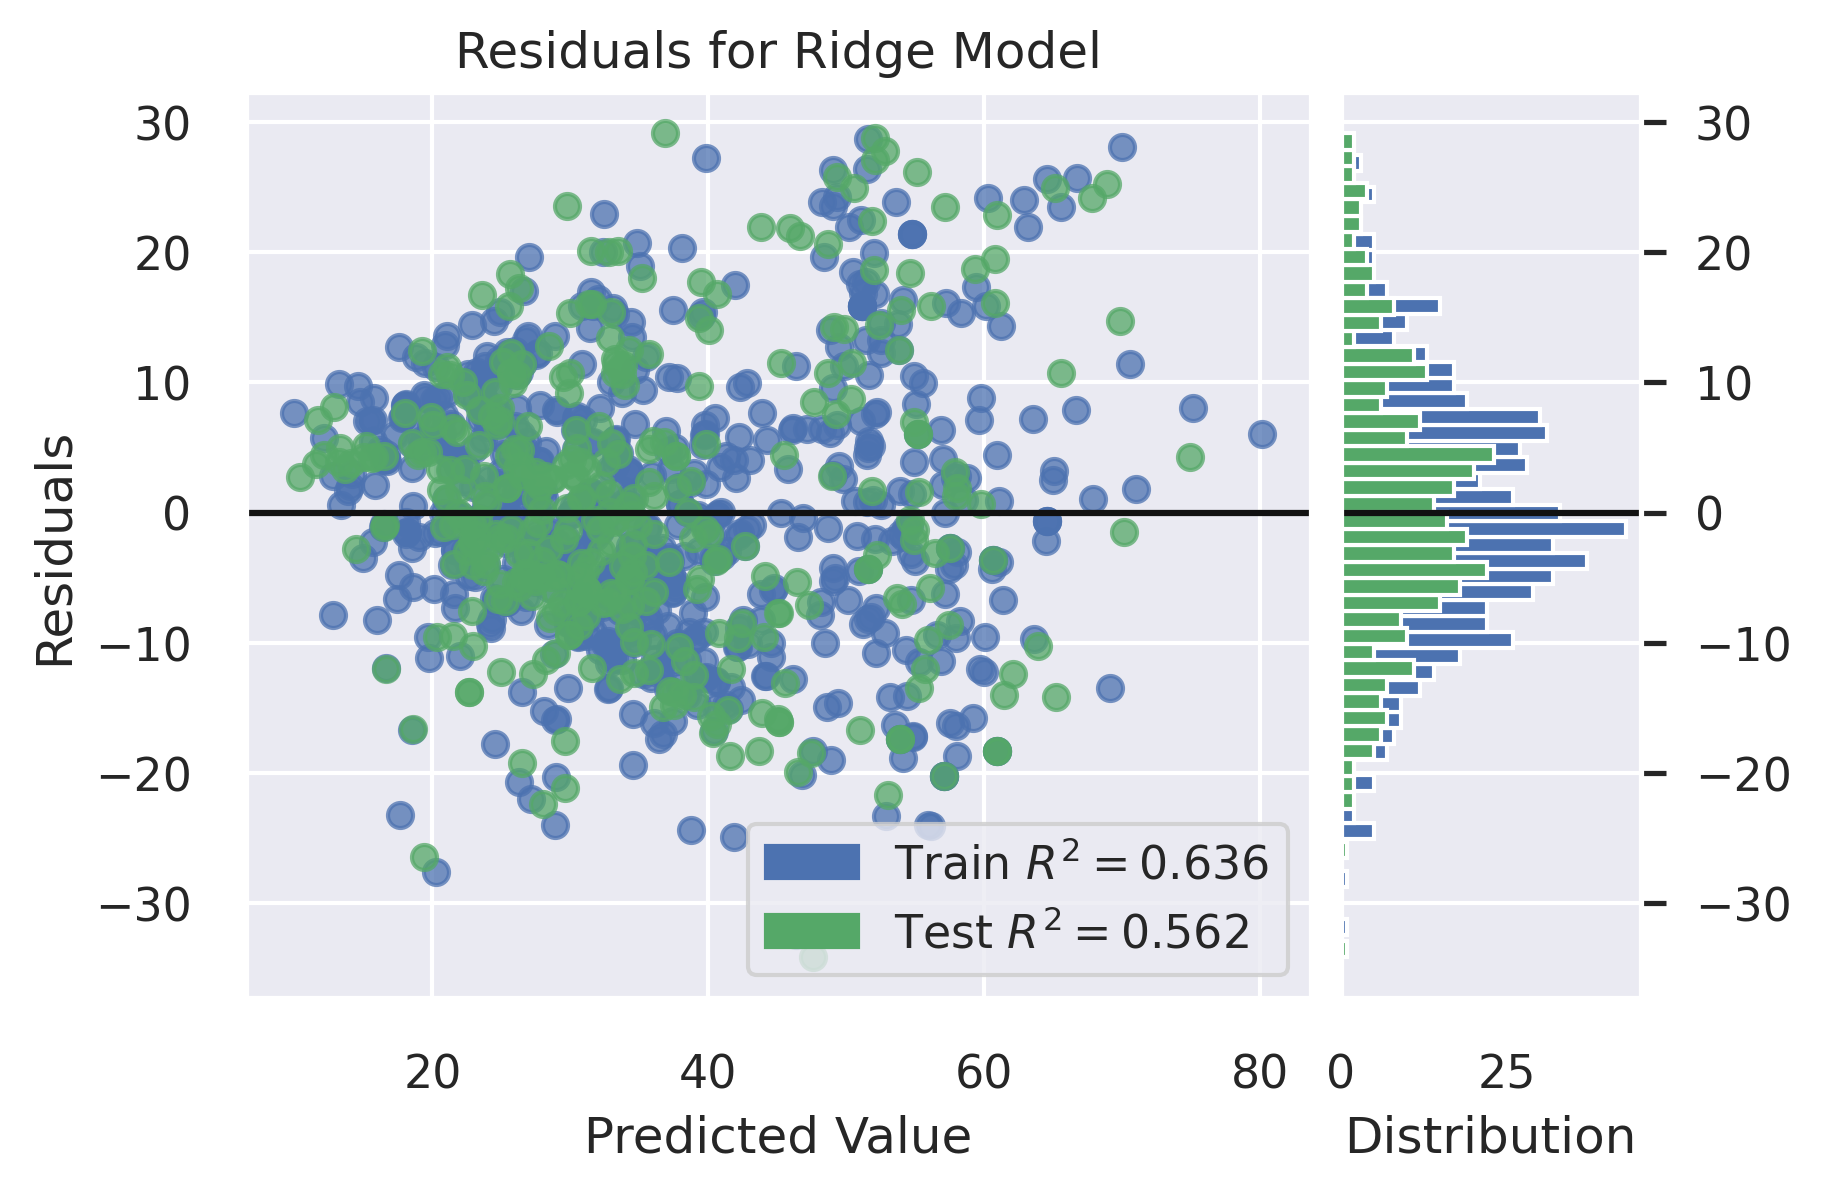

In [ ]:

visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()

In [ ]:
# import distributions
from scipy import stats
from scipy.stats import norm

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Residuals')]

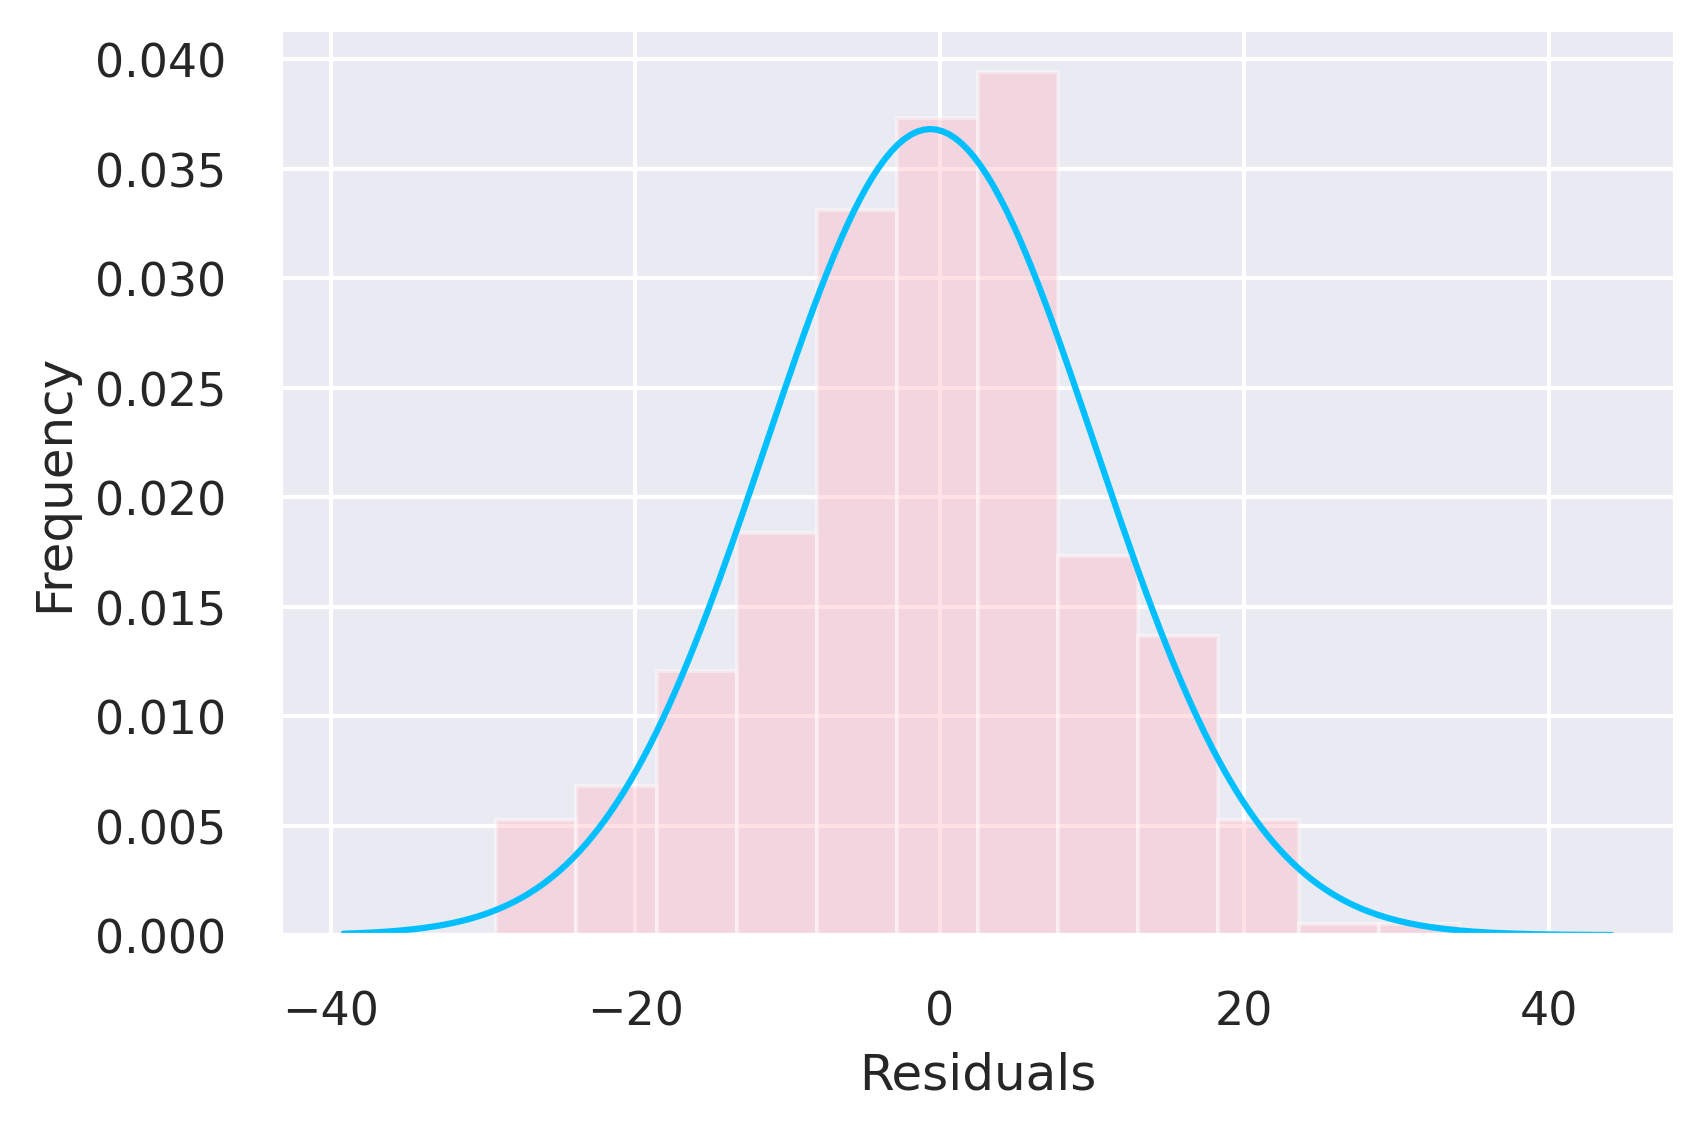

In [ ]:
ax1 = sns.distplot(residuals,
                                        
                  bins=12,
                  kde=False,
                  color='deepskyblue',
                  hist_kws={"color":'lightpink'},
                  fit=stats.norm,
                  fit_kws={"color":'deepskyblue'})
ax1.set(xlabel='Residuals', ylabel='Frequency')

In [ ]:
test, p = stats.shapiro(residuals)
print('The p-value (for having occurred by chance in a good match) is : '+str(p))

The p-value (for having occurred by chance in a good match) is : 0.050362154841423035


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


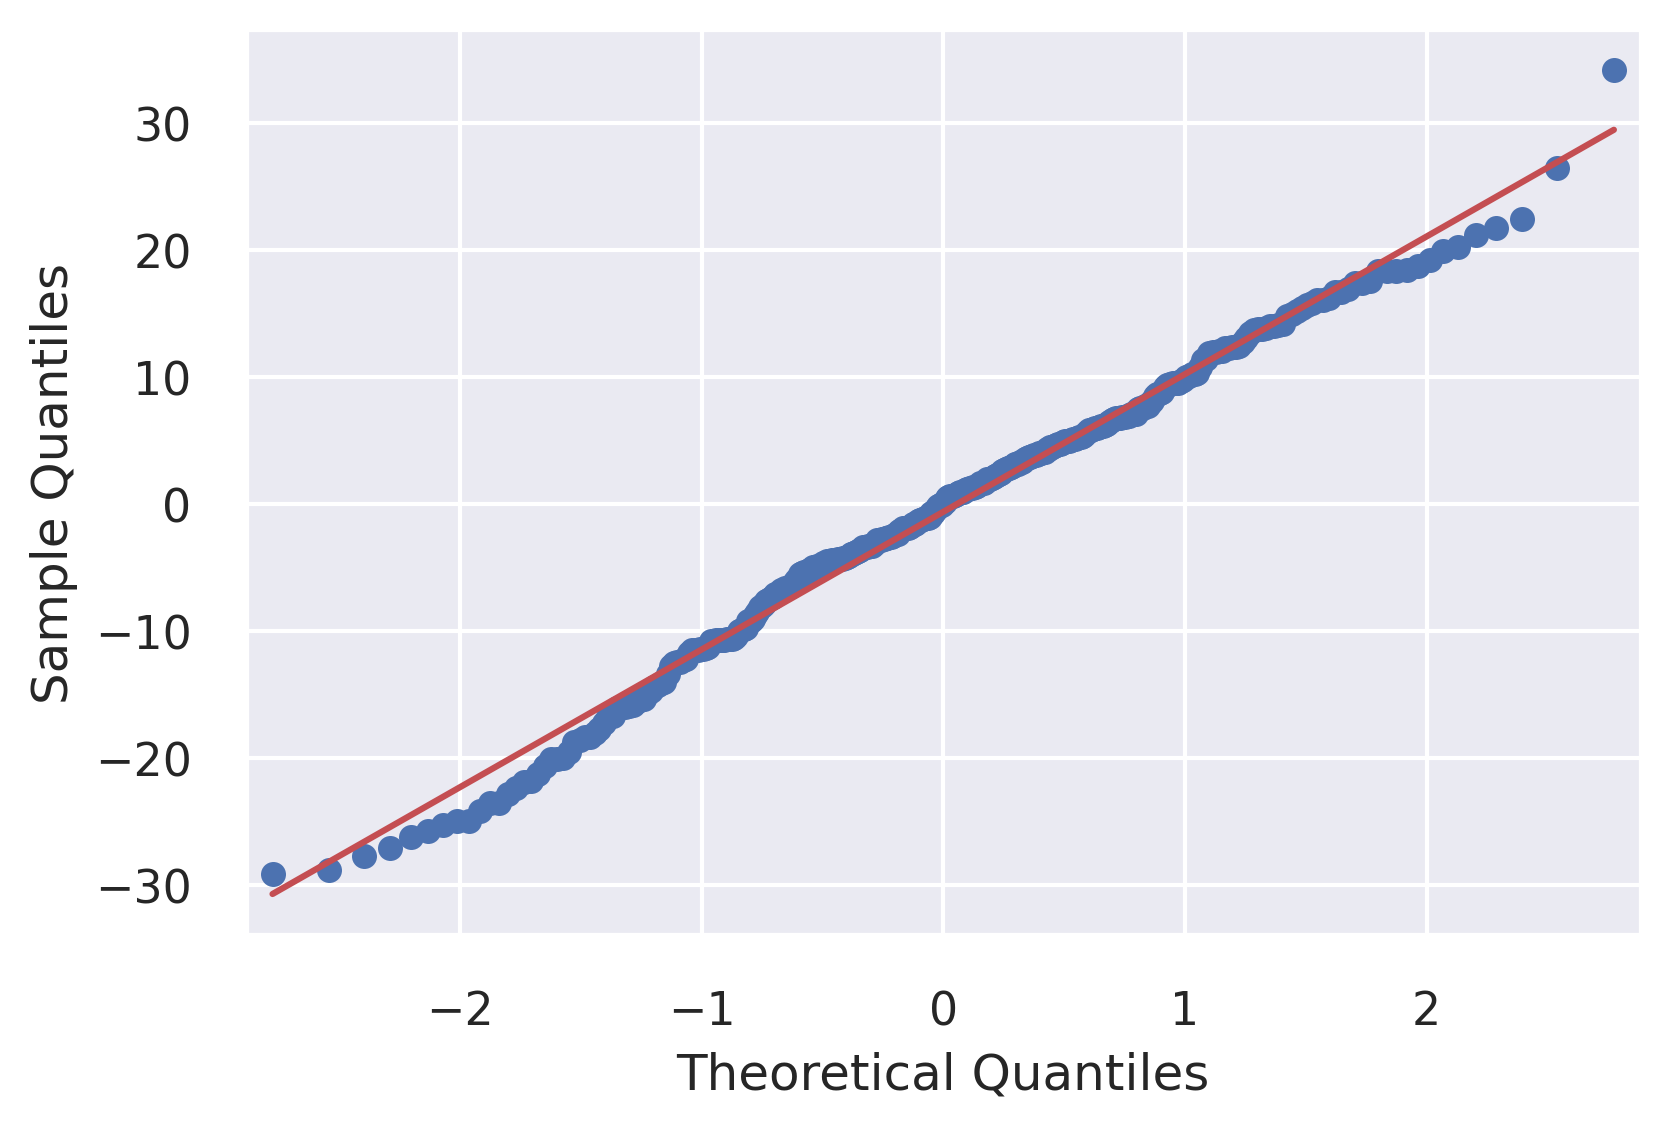

In [ ]:
import pylab
import statsmodels.api as sm
sm.qqplot(residuals, loc = 0, scale = 1, line='s')
pylab.show()

<font color='red'>Now let's try to create a non-linear function in the weights:

## <font color='blue'> Polynomial Regression</font>

<font color='slateblue'> Main idea: Linear combination of different powers of the feature values.

$$\large
P(x):= \beta_px^p+\beta_{p-1}x^{p-1}+...+\beta_1x+\beta_0
$$

IMPORTANT: P(x) is nonlinear in x. However if x is fixed (x is your data) and $\beta$ is the input we have
$$\large
L(\beta):= \beta_px^p+\beta_{p-1}x^{p-1}+...+\beta_1x+\beta_0
$$

is linear in $\beta$


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style("ticks")

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

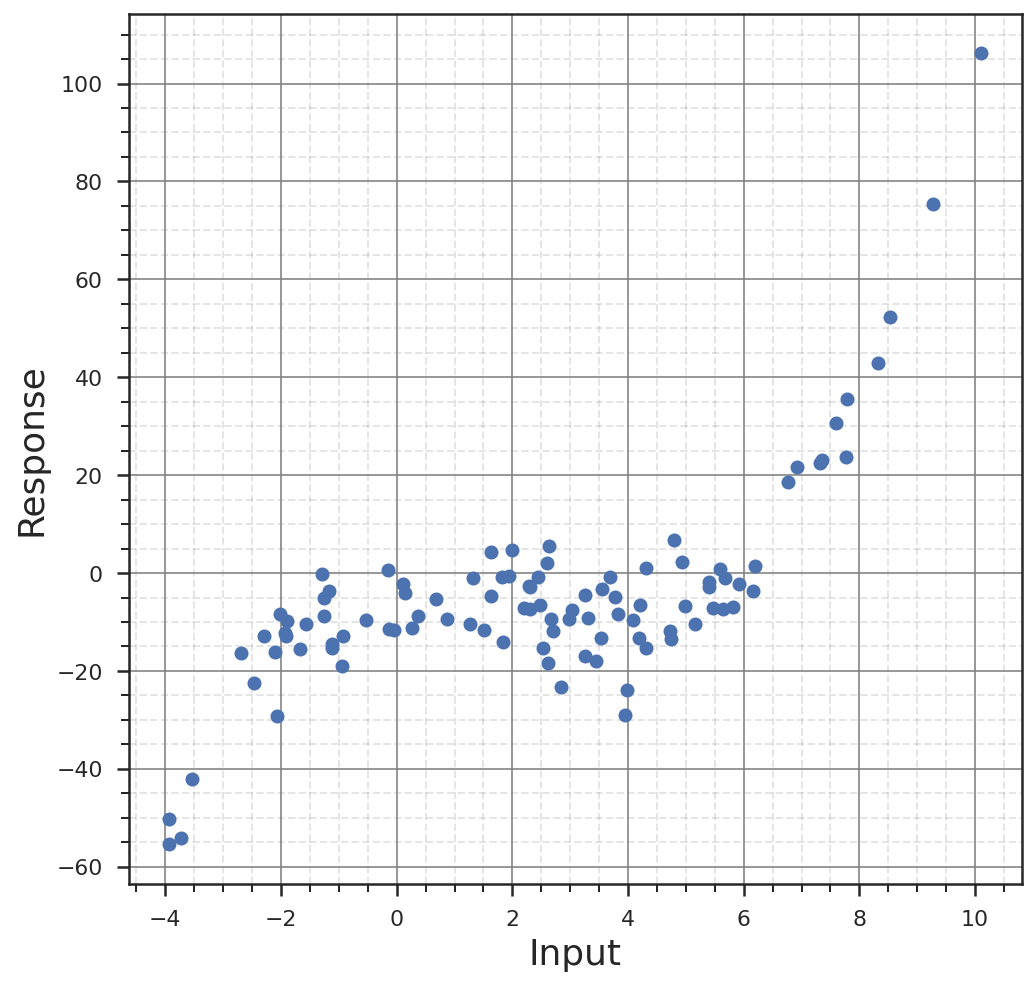

In [ ]:
np.random.seed(1693)
x = 2 - 3 * np.random.normal(0, 1, 100)
y = x - 1.5 * (x ** 2) + 0.25 * (x ** 3) + 2*np.random.normal(-3, 3, 100)
fig,ax = plt.subplots(figsize=(8,8))
plt.scatter(x,y)
ax.set_xlabel('Input',fontsize=18)
ax.set_ylabel('Response',fontsize=18)
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()
plt.show()

### <font color='fuchsia'> Is a straight line a good idea for capturing the aspect?

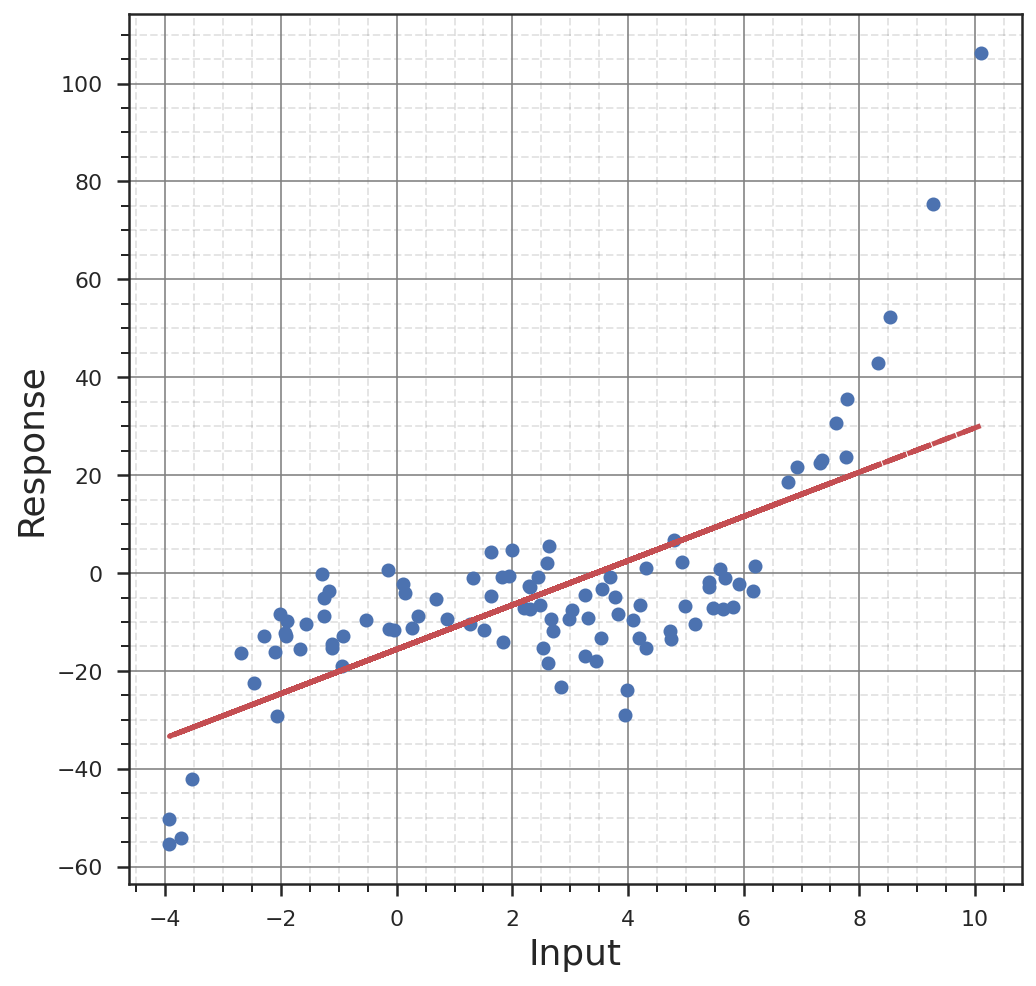

In [ ]:
from sklearn import linear_model
lm = linear_model.LinearRegression()

model = lm.fit(x.reshape((-1,1)),y)
y_pred = lm.predict(x.reshape((-1,1)))
fig,ax = plt.subplots(figsize=(8,8))
ax.scatter(x, y, color='cyan',edgecolors='k',s=60)
plt.plot(x, y_pred, '-',color='r',linestyle='--',lw=2.5)
ax.set_xlabel('Input',fontsize=18)
ax.set_ylabel('Response',fontsize=18)
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()
plt.show()

In [ ]:
import operator
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

6.443967644634603
0.9075020945627927


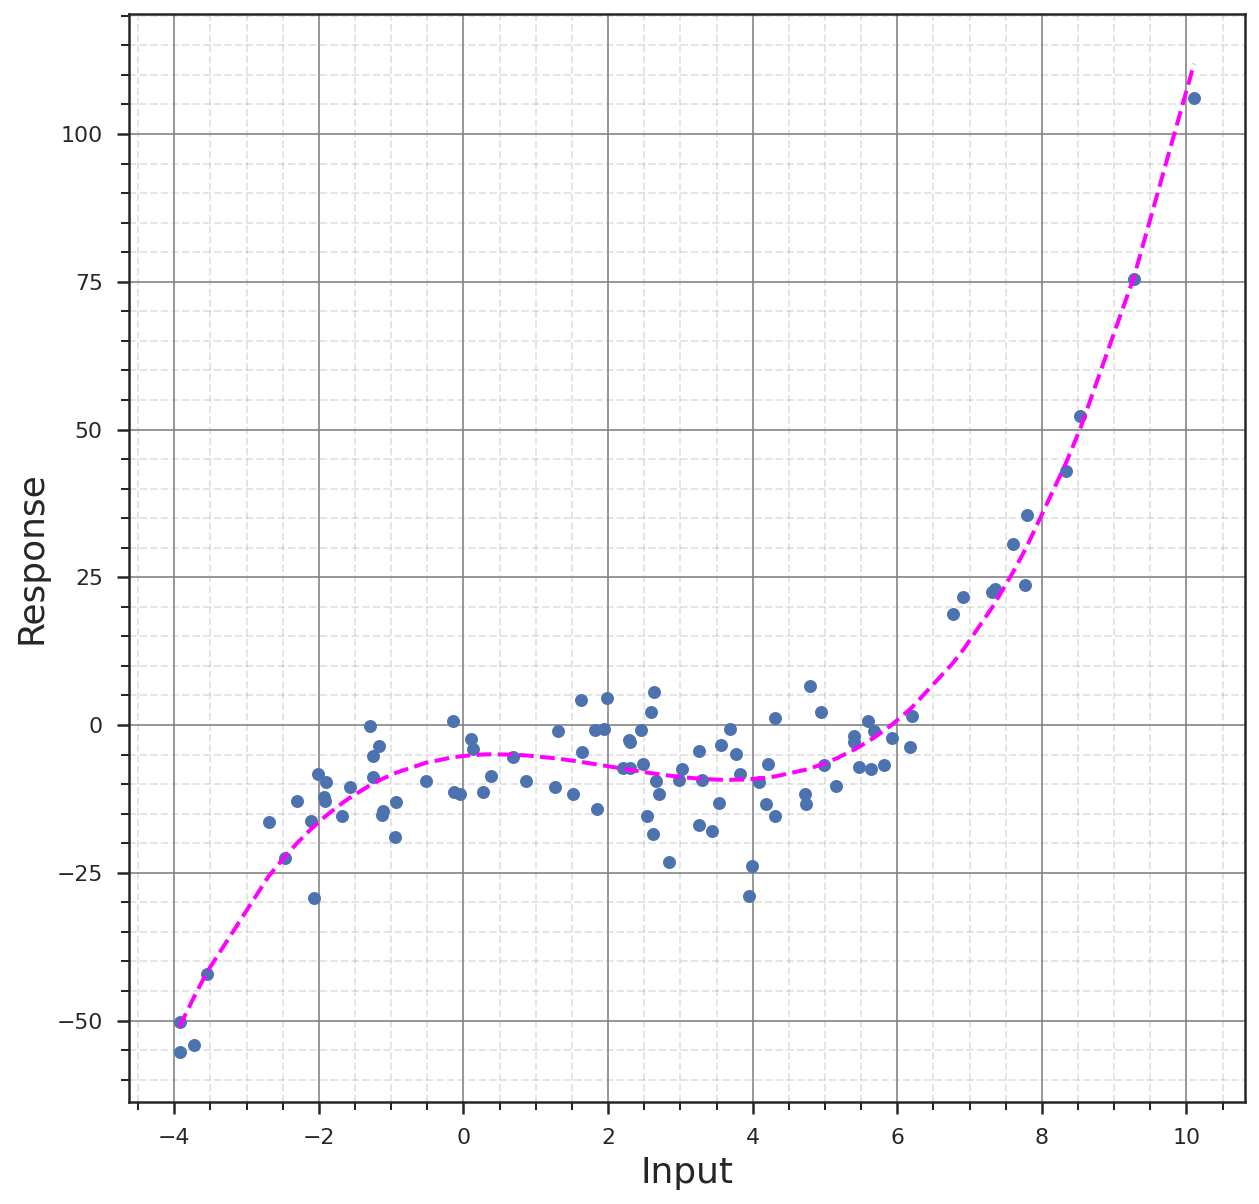

In [ ]:
np.random.seed(1693)
x = 2 - 3 * np.random.normal(0, 1, 100)

def f(x):
    sz = len(x)
    return x - 1.5 * (x ** 2) + 0.25 * (x ** 3) + 2 * np.random.normal(-3, 3, sz)

y = f(x)

polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(x.reshape((-1,1)))

# the model created is linear in weights 
model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)

fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(x, y, color='cyan',edgecolors='k',s=60)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
ax.plot(x, y_poly_pred, color='magenta',linestyle='--',lw=2)
ax.set_xlabel('Input',fontsize=18)
ax.set_ylabel('Response',fontsize=18)
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()
plt.show()

##<font color='blue'> Non-Linear that is not exactly a polynomial: A noisy sine wave</font>

In [ ]:
x = np.linspace(0,3.14,50)
epsilon = np.random.normal(scale=0.2,size=x.shape)
y = np.sin(4*x) + epsilon

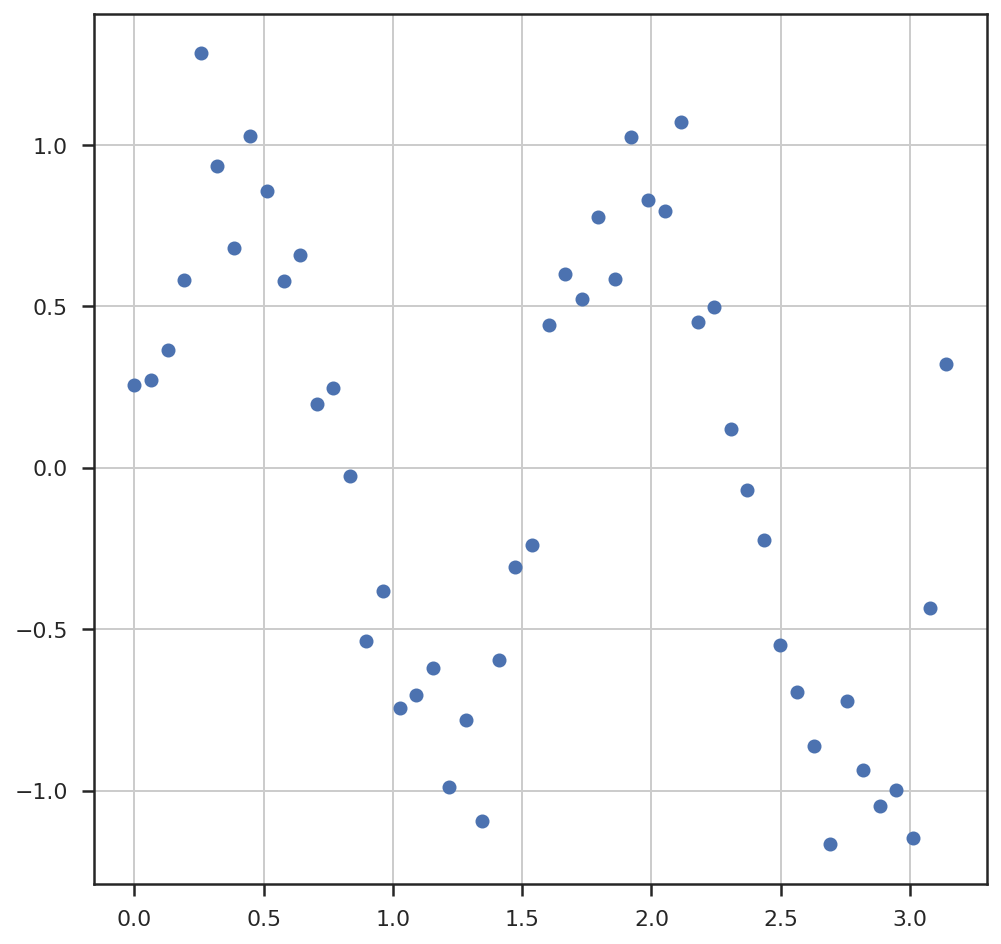

In [ ]:
plt.subplots(figsize=(8,8))
ax.scatter(x, y, color='cyan',edgecolors='k',s=60)
plt.grid(True)

In [ ]:
polynomial_features= PolynomialFeatures(degree=5)
x_poly = polynomial_features.fit_transform(x.reshape(-1,1))

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)

0.28634496310104374
0.8439787208105509


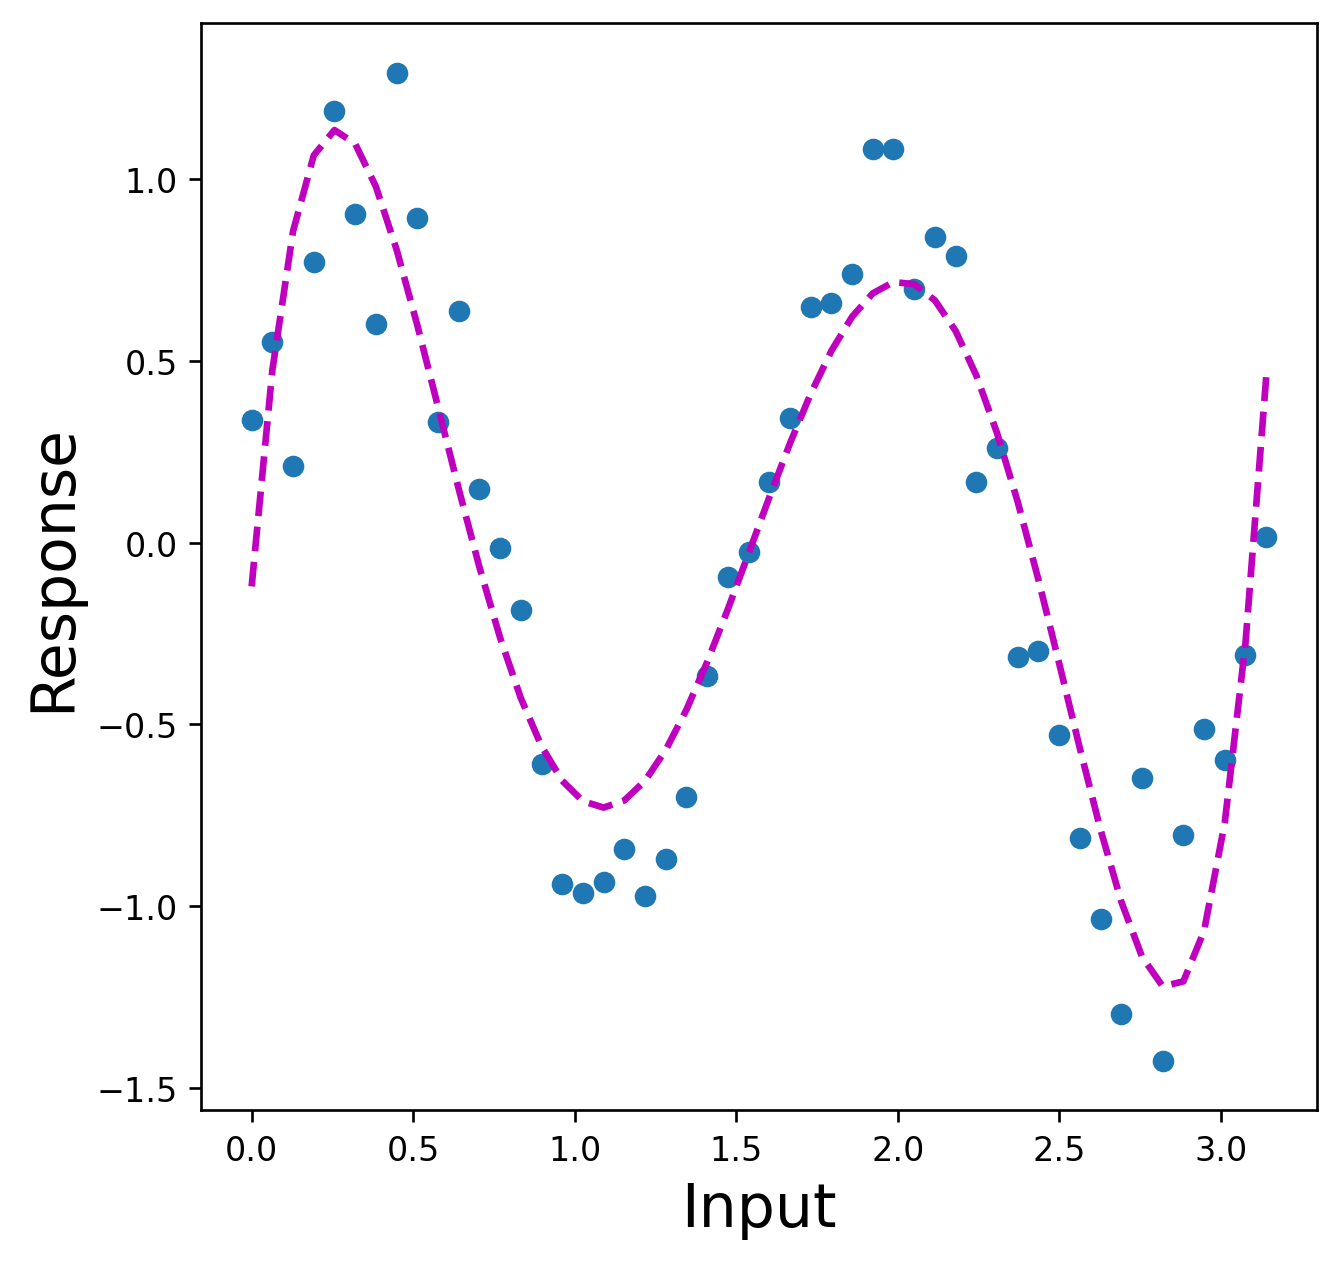

In [ ]:
plt.figure(figsize=(6,6))
ax.scatter(x, y, color='cyan',edgecolors='k',s=60)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='m',linestyle='--',lw=2)
plt.xlabel('Input',fontsize=18)
plt.ylabel('Response',fontsize=18)
plt.show()

## <font color='blue'> How do we know we are on the right track?

  - Use Train and Test Sets
  - Use Regularization.
  - Compute (R)MSE on the test set.
  - Compute the coefficient of determination on the test set.
  - Determine the normality of the residuals by using a test statistic (such as Shapiro-Wilk or Kolmogorov-Smirnov), density plots and *quantile-quantile* plots.


In [ ]:
import statsmodels.api as sm
from scipy import stats
import pylab

In [ ]:
# Create the random variables with mean 5, and sd 3
x_10 = stats.norm.rvs(loc=5, scale=3, size=10)
x_50 = stats.norm.rvs(loc=5, scale=3, size=50)
x_100 = stats.norm.rvs(loc=5, scale=3, size=100)
x_1000 = stats.norm.rvs(loc=5, scale=3, size=1000)
# Print the p values
print(stats.shapiro(x_10))
print(stats.shapiro(x_50))
print(stats.shapiro(x_100))
print(stats.shapiro(x_1000))

(0.8910931944847107, 0.1744469404220581)
(0.9747191667556763, 0.356033056974411)
(0.9940757155418396, 0.9436771273612976)
(0.9988580942153931, 0.7918404936790466)


In [ ]:
sm.qqplot(x_10, loc = 5, scale = 3, line='s')
sm.qqplot(x_50, loc = 5, scale = 3, line='s')
sm.qqplot(x_100, loc = 5, scale = 3, line='s')
sm.qqplot(x_1000, loc = 5, scale = 3, line='s')
pylab.show()